In [9]:
# Imports
%matplotlib notebook
import numpy as np
import pylgmath
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.text import Annotation
from pylgmath.so3.operations import vec2rot
import plotting
import sim
import local_solver

In [21]:
# camera parameters
f_u = 100 # focal length in horizonal pixels
f_v = 100 # focal length in vertical pixels
c_u = 50 # pinhole projection in horizonal pixels
c_v = 50 # pinhold projection in vertical pixels
b = 0.2 # baseline (meters)

M = sim.make_stereo_camera_matrix(f_u, f_v, c_u, c_v, b)
R = 10 * np.eye(4) # covarience matrix for image-space noise


<IPython.core.display.Javascript object>


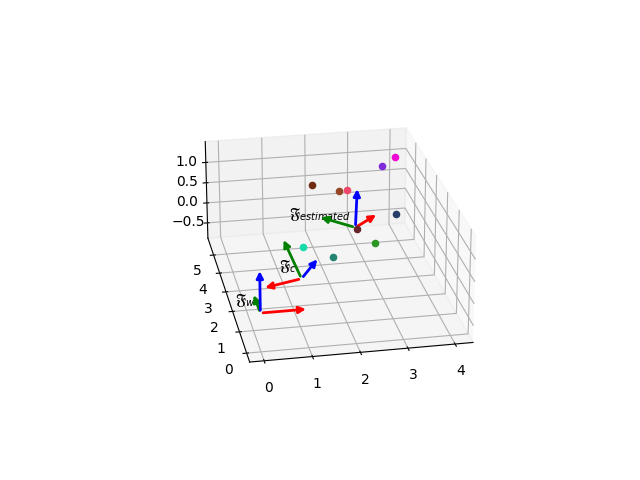

<IPython.core.display.Javascript object>


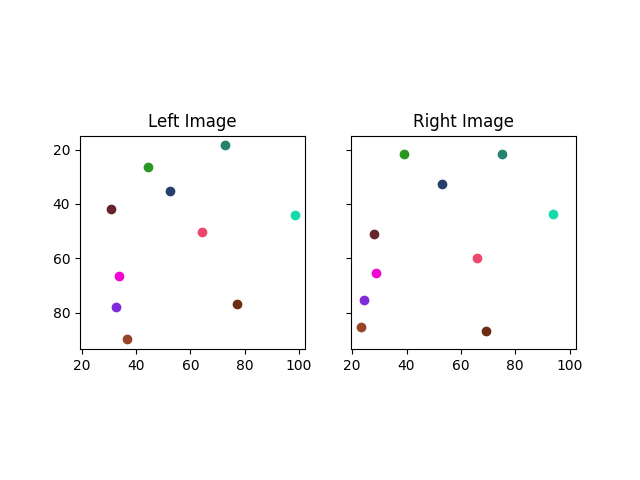

In [28]:
# make random camera pose
a = np.random.rand(3, 1)
theta = np.random.rand() * 2*np.pi
C_wc = vec2rot(theta * a/np.linalg.norm(a))
T_wc = np.eye(4)
T_wc[:3, :3] = C_wc
T_wc[:-1, -1] = [3*np.random.rand(), 3*np.random.rand(), 0]

# make sim instance w/ N points
N = 10
fig, ax, p_w, colors = sim.make_stereo_sim_instance(N, T_wc, np.array([[-1,1], [-1, 1], [2, 5]]))

# Generative camera model 
T_cw = np.linalg.inv(T_wc)
y = sim.generative_camera_model(M, T_cw, p_w)
dy = sim.generate_stereo_camera_noise(R, size = 10)[:, :, None]
y = y + dy
camfig, (l_ax, r_ax) = sim.render_camera_points(y, colors)

## Stereo Localization Problem
$$\mathbf{T_{cw}} = \frac{1}{2} \text{argmin}_{\mathbf{T}} \sum_k (\mathbf{y}_k - \mathbf{M} \frac{1}{z_k} \mathbf{T} \mathbf{p}_k)^T \mathbf{W}_k (\mathbf{y}_k - \mathbf{M} \frac{1}{z_k} \mathbf{T} \mathbf{p}_k)$$
$$\mathbf{T} \in SE(3)$$
$$z_k = \mathbf{a}^T \mathbf{T} \mathbf{p}_k$$


## Local Solver
Let $\mathbf{x} = \mathbf{T}\mathbf{p}_k$,
$$\mathbf{u}_k(\mathbf{x}) = \mathbf{y}_k - \frac{1}{\mathbf{a}^T\mathbf{x}} \mathbf{M} \mathbf{x}$$

We want to find a perturbation $\mathbf{\epsilon}^*$ so we can iterativly update our estimate $\mathbf{T}$:
$$\mathbf{T} \leftarrow \exp(\mathbf{\epsilon}^{*^{\curlywedge}}) \mathbf{T}_{op}$$

$$\mathbf{u}_k(\mathbf{T} \mathbf{p}_k) \approx \mathbf{u}_k(\mathbf{T}_{op}\mathbf{p}_k) + \frac{\partial \mathbf{u}_k}{\partial \mathbf{x}}|_{\mathbf{x} = \mathbf{T}_{op} \mathbf{p}_k} (\mathbf{T}_{op}\mathbf{p}_k)^{\odot} \mathbf{\epsilon}$$
$$\mathbf{u}_k(\mathbf{T} \mathbf{p}_k) \approx \mathbf{\beta}_k + \mathbf{\delta}^T\mathbf{\epsilon}$$

where
$$\delta_k^T = \frac{\partial \mathbf{u}_k}{\partial \mathbf{x}}|_{\mathbf{x} = \mathbf{T}_{op} \mathbf{p}_k} (\mathbf{T}_{op}\mathbf{p}_k)^{\odot},$$
$$\beta_k = \mathbf{u}_k(\mathbf{T}_{op}\mathbf{p}_k),$$
$$\frac{\partial \mathbf{u}(\mathbf{x})}{\partial \mathbf{x}} = \left(\frac{1}{\mathbf{a}^T \mathbf{x}}\right)^2 \mathbf{M} \mathbf{x} \mathbf{a}^T - \frac{1}{\mathbf{a}^T \mathbf{x}} \mathbf{M}$$

Inserting this back into the cost function
$$\mathcal{L} = \frac{1}{2} \sum_k (\mathbf{\beta}_k + \mathbf{\delta}^T\mathbf{\epsilon})^T \mathbf{W}_k (\mathbf{\beta}_k + \mathbf{\delta}^T\mathbf{\epsilon}),$$

and differentiating w.r.t $\mathbf{\epsilon}$ we obtain
$$\frac{\partial \mathcal{L}}{\partial \mathbf{\epsilon}} = \frac{1}{2} \sum_k \mathbf{\delta}_k (\mathbf{W}_k + \mathbf{W}_k^T) (\mathbf{\beta}_k + \mathbf{\delta}_k^T \mathbf{\epsilon})$$

Setting this to zero and rearranging, we find an expression that we can solve for $\mathbf{\epsilon}^*$:
$$\sum_k (\mathbf{\delta}_k (\mathbf{W}_k + \mathbf{W}_k^T) \mathbf{\delta}_k^T) \mathbf{\epsilon^*} = - \sum_k \mathbf{\delta}_k (\mathbf{W}_k + \mathbf{W}_k^T)\mathbf{\beta}_k$$


In [29]:
T_op = np.eye(4)
W = np.eye(4)

max_iters = 1000
perturb_mag = np.inf

T_op = local_solver.stereo_localization_gauss_newton(T_op, y, p_w, W, M)

print("Estimate:\n", T_op)
print("Ground Truth:\n", T_cw)

Loss: 1721457.4003734281
Loss: 26485902.389582057
Loss: 7595260.827193123
Loss: 2436914.053967409
Loss: 1448703.5239388004
Loss: 40054537.33231871
Loss: 12565402.917252684
Loss: 3783264.2462600074
Loss: 1712914.6925904918
Loss: 2647064.2585160723
Loss: 1553152.320121234
Loss: 2587649.4820604785
Loss: 1447884.4515384866
Loss: 1666479.9319146932
Loss: 1455022.6744837242
Loss: 1626074.2780138478
Loss: 1525537.0514893448
Loss: 1535482.7193811645
Loss: 1711575.2454043662
Loss: 1457911.2682725363
Loss: 1703490.1409567995
Loss: 1455341.076739266
Loss: 1748970.38783472
Loss: 1440038.244574817
Loss: 2150907.5653910176
Loss: 1460303.6571004624
Loss: 2915463.9280495597
Loss: 1433498.304968178
Loss: 1403115.5734359391
Loss: 1572613.0999889614
Loss: 1704658.4207921827
Loss: 1425658.450268414
Loss: 1443392.925937744
Loss: 2843902.2781194435
Loss: 1430164.9100765826
Loss: 1728293.704506008
Loss: 1443772.0681915113
Loss: 1510115.4352342736
Loss: 1525336.8707147047
Loss: 1584689.9917274266
Loss: 153871

Loss: 1710441.5255375726
Loss: 1498984.1438507317
Loss: 1417986.8710839564
Loss: 1875964.9289000991
Loss: 1368101.364194881
Loss: 1389325.5646291652
Loss: 1639317.410260458
Loss: 1494043.7015539133
Loss: 1451795.356769945
Loss: 1828591.3739685076
Loss: 1384481.8112355527
Loss: 1442408.546202423
Loss: 1579942.1194455286
Loss: 1578712.510679718
Loss: 1371501.9190810863
Loss: 1848534.6697129675
Loss: 1351471.3257599534
Loss: 1468860.217800032
Loss: 1701089.7324574785
Loss: 1482746.3705090526
Loss: 1521626.0661965355
Loss: 1624995.3083422778
Loss: 1855806.0928348578
Loss: 1413631.0006627452
Loss: 1677558.853473323
Loss: 1474099.9527115105
Loss: 1941415.1192307023
Loss: 1422254.6155223444
Loss: 1806851.1027440156
Loss: 1403242.831479548
Loss: 1639059.5062312323
Loss: 1812803.1650425855
Loss: 1331485.4188428675
Loss: 1396809.3926408268
Loss: 2036345.1896433353
Loss: 1388007.937708064
Loss: 1718906.7767193608
Loss: 1856400.7529269282
Loss: 1414231.1926406575
Loss: 1426815.9514557272
Loss: 199

Loss: 1494138.7282705444
Loss: 1615576.1825674959
Loss: 1408363.1241567011
Estimate:
 [[ 6.85874675e-01  7.27564435e-01 -1.50307765e-02 -4.85721241e+00]
 [-7.26788217e-01  6.85895348e-01  3.64205870e-02 -7.37060520e-01]
 [ 3.68078635e-02 -1.40557670e-02  9.99223507e-01  1.22246791e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Ground Truth:
 [[-0.75828969  0.51813419 -0.39564342  0.07822231]
 [-0.37485646  0.14998527  0.91486997  0.19563623]
 [ 0.53336609  0.84204595  0.08049367 -1.83907097]
 [ 0.          0.          0.          1.        ]]


<IPython.core.display.Javascript object>


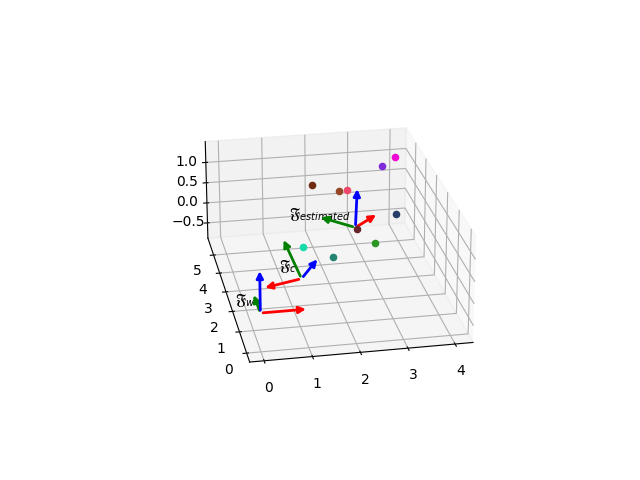

In [30]:
#visualize solution
plotting.add_coordinate_frame(np.linalg.inv(T_op), ax, "$\mathfrak{F}_{estimated}$")
fig